In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as ptch

from datetime import datetime
from datetime import timedelta

import time
from os import listdir
from os.path import isfile, join
import re

plt.rcParams.update(plt.rcParamsDefault)

In [2]:
!pip freeze > requirements.txt

# Non-Pharmaceutical Interventions in Canada

Here we show comparisons of descriptive statistics for each regional and subregional-level dataset across Canada. Download individual region CSVs from the Google Sheet and place them in `./data/`. 

Stats Canada data on population size by province available from: 

Statistics Canada. Table 17-10-0009-01 Population estimates, quarterly"
https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901
DOI: https://doi.org/10.25318/1710000901-eng


In [3]:
cutoff_date = datetime(2020, 5, 18)

In [4]:
stats_columns=[
    'file',
    'region',
    'subregion', 
    'rows',
    'columns',
    'start_date.min', 
    'start_date.max', 
    'end_date.min', 
    'end_date.max', 
    'end_date.count / count', 
    'reviewer.unique', 
    'intervention_summary.unique', 
    'intervention_category.unique',
    'target_population_category.unique',
    'target_population_category (% not "General")',
    'enforcement_category.unique',
    'oxford_government_response_category.notna',
    'oxford_government_response_category.unique',
    'oxford_fiscal_measure_cad.sum',
    'source_url.unique'
]

columns=[
    'start_date',
    'end_date',
    'reviewer',
    'country',
    'region',
    'subregion',
    'intervention_summary',
    'intervention_category',
    'target_population_category',
    'enforcement_category',
    'oxford_government_response_category',
    'oxford_closure_code',
    'oxford_public_info_code',
    'oxford_travel_code',
    'oxford_geographic_target_code',
    'oxford_fiscal_measure_cad',
    'oxford_monetary_measure',
    'oxford_testing_code',
    'oxford_tracing_code',
    'oxford_restriction_code',
    'oxford_income_amount',
    'oxford_income_target',
    'oxford_debt_relief_code',
    'source_url',
    'source_organization',
    'source_organization_2',
    'source_category',
    'source_title',
    'source_full_text',
    'note',
    'end_source_url',
    'end_source_organization',
    'end_source_organization_2',
    'end_source_category',
    'end_source_title',
    'end_source_full_text'
]

In [5]:
population_df = pd.read_csv('data/statscan-population-q.csv', thousands=',')
population_df[['Geography', 'Q1 2020']]
population_df['region'] = population_df['Geography']
population_df['population_q1_2020'] = pd.to_numeric(population_df['Q1 2020'])
population_df = population_df[['region', 'population_q1_2020']]
population_df

,region,population_q1_2020
0,Canada,37894799
1,Newfoundland and Labrador,521365
2,Prince Edward Island,158158
3,Nova Scotia,977457
4,New Brunswick,779993
5,Quebec,8537674
6,Ontario,14711827
7,Manitoba,1377517
8,Saskatchewan,1181666
9,Alberta,4413146


In [6]:
full_df = pd.read_csv('SCHEMA UPDATE - Collecting NPIs Effects - FULL.csv', error_bad_lines=False)
full_df['start_date'] = pd.to_datetime(full_df['start_date'], format='%m/%d/%Y', errors='coerce')
full_df['end_date'] = pd.to_datetime(full_df['end_date'], format='%m/%d/%Y', errors='coerce')
full_df['oxford_fiscal_measure_cad'] = full_df['oxford_fiscal_measure_cad'].replace('[\$,]', '', regex=True).astype(float)



In [7]:
full_df = full_df[full_df['start_date'] <= cutoff_date]
full_df = full_df[~full_df['start_date'].isna()]

provinces_df = full_df[full_df['subregion'].isna() & full_df['region'].notna() & (full_df['region'] != "All")]

federal_df = full_df[full_df['subregion'].isna() & (full_df['region'].isna() | (full_df['region'] == "All"))]

In [8]:
full_df.shape

(3308, 35)

In [9]:
provinces_df.shape

(1727, 35)

In [10]:
federal_df.shape

(109, 35)

In [12]:
object_columns = full_df.dtypes[full_df.dtypes == 'object'].index.values
full_df[object_columns] = full_df[object_columns].replace('\n',' ', regex=True)
full_df.shape

(3308, 35)

In [13]:
full_df.drop(columns=['reviewer']).to_csv('npi_canada.csv')
#provinces_df.drop(columns=['reviewer']).to_csv('npi_by_province.csv')
#federal_df.drop(columns=['reviewer']).to_csv('npi_federal.csv')

# Descriptive Statistics for Paper

In [14]:
print("Number of interventions recorded: ", full_df.shape[0])

Number of interventions recorded:  3308


In [15]:
print("Number of oxford interventions recorded: ", full_df['oxford_government_response_category'].count())

Number of oxford interventions recorded:  1599


In [16]:
#n = full_df[full_df['oxford_government_response_category'].isin(['S8 Fiscal measures', 'S9 Monetary measures (interest rate)', 'S10 Emergency investment in health care', 'S11 Investment in vaccines', 'S12 Testing policy', 'S13 Contact tracing'])]['oxford_government_response_category'].count()
#print("Number of oxford interventions in Stringency Index recorded (S1-S7): ", n)

In [17]:
#n / full_df.shape[0]

In [18]:
print("Number of unique source urls: ", len(full_df['source_url'].unique()))

Number of unique source urls:  1987


In [19]:
print("Number of unique primary source organizations: ", len(full_df['source_organization'].unique()))

Number of unique primary source organizations:  261


In [20]:
oxford_ratio = full_df['oxford_government_response_category'].count() / full_df['intervention_category'].count()
print("% of interventions with oxford classifications: ", oxford_ratio)



% of interventions with oxford classifications:  0.4838124054462935


In [21]:
full_df['oxford_government_response_category'].value_counts().sort_index()

C1 School Closing                            57
C2 Workplace Closures                       262
C3 Cancel public events                     116
C4 Public Gathering Restrictions             74
C5 Close public transport                     9
C6 Stay at Home                               7
C7 Restrictions on internal movements       190
C8 International Travel Controls             77
E1 Income Support                            33
E2 Debt / Contract Relief for Households     79
E3 Fiscal measures                          239
E4 Support for Other Countries                2
H1 Public Info Campaigns                    291
H2 Testing policy                            64
H3 Contact tracing                            6
H4 Emergency investment in health care       81
H5 Investment in vaccines                    12
Name: oxford_government_response_category, dtype: int64

In [22]:
assert full_df['oxford_government_response_category'].nunique() == 17

In [23]:
print("Number of regions: ", full_df['country'].nunique())
print("Number of regions: ", full_df['region'].nunique())
print("Number of subregions: ", full_df['subregion'].nunique())

#assert full_df['country'].nunique() == 1 # canada
assert full_df['region'].nunique() == 15 # 13 provinces + nan + All
assert full_df['subregion'].nunique() == 21

Number of regions:  2
Number of regions:  15
Number of subregions:  25


AssertionError: 

# NPIs before Key Dates

In [24]:
full_11_df = full_df[full_df['start_date'] < '2020-03-11']
print("Number of interventions recorded before may 11: ", full_11_df.shape[0])
print("Number of interventions recorded before may 11 (%): ", full_11_df.shape[0] / full_df.shape[0])


Number of interventions recorded before may 11:  135
Number of interventions recorded before may 11 (%):  0.040810157194679564


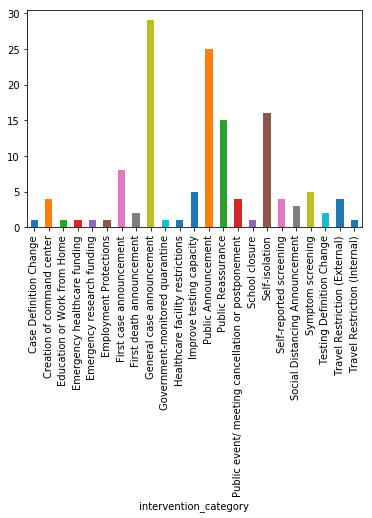

In [25]:
full_11_df.groupby(by='intervention_category')['start_date'].count().plot.bar()

In [26]:
full_1_df = full_df[full_df['start_date'] < '2020-01-25'] # first case
print("Number of interventions recorded before Jan 25: ", full_1_df.shape[0])
print("Number of interventions recorded before Jan 25 (%): ", full_1_df.shape[0] / full_df.shape[0])


Number of interventions recorded before Jan 25:  9
Number of interventions recorded before Jan 25 (%):  0.002720677146311971


In [27]:
9 / full_df.shape[0]

0.002720677146311971

In [28]:
full_1_df['intervention_category'].unique()

array(['Public Announcement', 'Public Reassurance', 'Symptom screening',
       'Improve testing capacity', 'Self-reported screening'],
      dtype=object)

## NPI: Enforcement Categories


In [29]:
len(full_df['enforcement_category'].unique())

6

In [30]:
full_df.groupby(by='enforcement_category').count().max(axis=1).sort_values()

enforcement_category
Arrest                 8
Legal Action          42
Fines                 99
Refusal of Entry     180
Not Applicable      2900
dtype: int64

Text(0.5,0,'count')

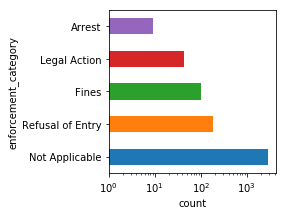

In [31]:
full_df.groupby(by="enforcement_category").count().max(axis=1).sort_values(ascending=False).plot.barh(log=True, figsize=(3,3))
plt.xlabel('count')

## Target Population Categories

In [32]:
len(full_df['target_population_category'].unique())

18

Text(0.5,0,'count')

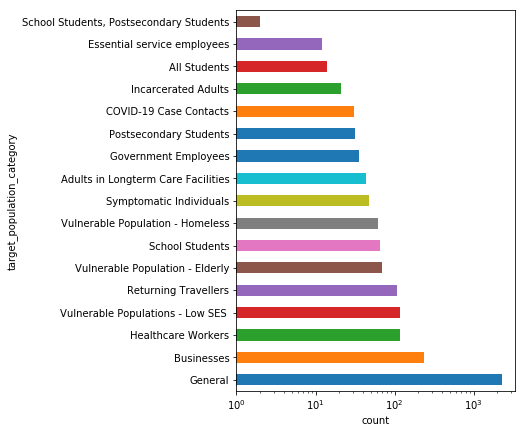

In [33]:
full_df.groupby(by="target_population_category").count().max(axis=1).sort_values(ascending=False).plot.barh(log=True, figsize=(5,7))
plt.xlabel('count')

## NPI: Intervention Categories

In [34]:
n_interventions_unique = len(full_df['intervention_category'].unique())
print('Unique interventions: ', n_interventions_unique)
assert n_interventions_unique == 61

Unique interventions:  61


Lets show examples of the top 15 interventions by count

In [35]:
intervention_counts = pd.DataFrame(full_df.groupby(by='intervention_category').count().max(axis=1))

In [36]:
pd.set_option('display.max_colwidth', -1)

examples = pd.DataFrame(full_df.groupby(by='intervention_category').apply(lambda x: x.sample(1, random_state=3)['intervention_summary'].values[0]))

intervention_counts.merge(examples, left_index=True, right_index=True).sort_values(by='0_x', ascending=False)[0:17]



,0_x,0_y
intervention_category,,
Public Announcement,511,Mayor reminder to maintain social distancing in parks
General case announcement,358,There are 3 more deaths and 15 new cases.
Emergency economic funding,224,"Tax payment relief for businesses (corporate tax, property tax, tourism levy)"
Social Distancing Announcement,171,Update on importance of physical distancing enforcement
Emergency social services funding,159,Contribution to Centraide's COVID-19 Emergency Fund
Administrative flexibility,120,tax return filing deadlines are being altered and remission of interest and penalties is available
Self-isolation,102,Recommendation that all travellers returning to PEI monitor symptoms and voluntarily self-islote
Public event/ meeting cancellation or postponement,102,Fireworks Ban
Recreational / Entertainment Facility Closure or Restriction,101,Provincial Guidance: Closure of casinos


In [37]:
full_df[full_df['oxford_government_response_category'].isna()].groupby(by='intervention_category').count().max(axis=1).sort_values(ascending=False)


intervention_category
Public Announcement                                             368
General case announcement                                       324
Administrative flexibility                                      97 
Social Distancing Announcement                                  67 
Emergency social services funding                               63 
Declaration of emergency (or similar)                           57 
Healthcare facility restrictions                                57 
Public park restriction or closure                              49 
Health workforce task-shifting                                  44 
Recreational / Entertainment Facility Closure or Restriction    43 
Public Reassurance                                              42 
Social Service provider restrictions                            35 
Improve testing capacity                                        30 
Increased sanitation measures                                   29 
Creation of command center

Text(0.5,0,'count')

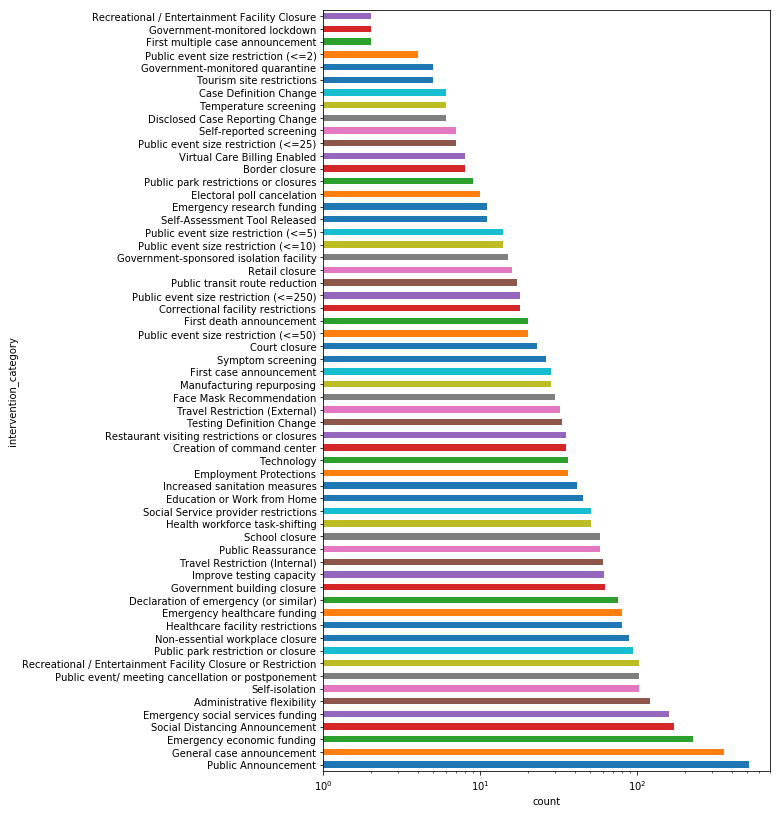

In [38]:

full_df.groupby(by="intervention_category").count().max(axis=1).sort_values(ascending=False).plot.barh(log=True, figsize=(8,14))
plt.xlabel('count')


# Sources

Looking at unique source urls, organizations, and source types

In [39]:
a = full_df['source_organization'].unique()
a.shape

(261,)

In [40]:
b = full_df['source_organization_2'].unique()

In [41]:
all_sources = list(set(a) | set(b))
len(all_sources)

378

## NPI: Fiscal Measures

Show investments by province or subregion

In [42]:
#fig, ax = plt.subplots(figsize=(12,10))

dates = pd.date_range(start='03-01-2020', end='05-20-2020', name='dates').to_series() #mm-dd-yyyy
gb = provinces_df[provinces_df['oxford_fiscal_measure_cad'].notna()][['start_date', 'region', 'oxford_fiscal_measure_cad']].groupby(by='region')
provinces_fiscal = pd.DataFrame(dates)

for g_name, g_df in gb:
    all_dates_df = g_df.join(dates, on='start_date', how='right')
    all_dates_df['oxford_fiscal_measure_cad'] = all_dates_df['oxford_fiscal_measure_cad'].fillna(0)
    all_dates_df = all_dates_df.sort_values(by='start_date', ascending=True)
    all_dates_df['cumulative'] = all_dates_df['oxford_fiscal_measure_cad'].cumsum(axis=0)
    all_dates_df.set_index('start_date')
    all_dates_df = all_dates_df.groupby(by='start_date').sum()

    provinces_fiscal[g_name] = all_dates_df['cumulative']

#plt.yscale('log')
#plt.title('')
#plt.ylabel('Fiscal Interventions ($)')
#plt.xlabel('Date')

#provinces_fiscal

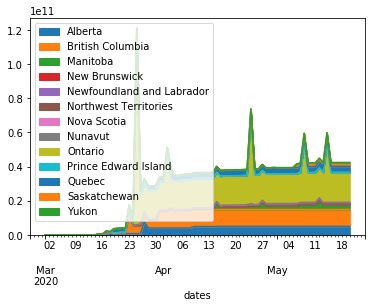

In [43]:
print("WARNING: Not Correct Yet")
provinces_fiscal.drop(['dates'], axis=1).plot.area()

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))

dates = pd.date_range(start='03-01-2020', end='05-20-2020', name='dates').to_series() #mm-dd-yyyy
gb = provinces_df[provinces_df['oxford_fiscal_measure_cad'].notna()][['start_date', 'region', 'oxford_fiscal_measure_cad']].groupby(by='region')

for g_name, g_df in gb:
    all_dates_df = g_df.join(dates, on='start_date', how='right')
    all_dates_df['oxford_fiscal_measure_cad'] = all_dates_df['oxford_fiscal_measure_cad'].fillna(0)
    all_dates_df = all_dates_df.sort_values(by='start_date', ascending=True)
    all_dates_df['oxford_fiscal_measure_cad_cumsum'] = all_dates_df['oxford_fiscal_measure_cad'].cumsum(axis=0)
    #print(all_dates_df)
    all_dates_df.plot(x='start_date', y='oxford_fiscal_measure_cad_cumsum', label=g_name, ax=ax)

plt.yscale('log')

In [ ]:
full_df.groupby(by=['region']).count().max(axis=1).plot.barh()

In [ ]:
full_df.groupby(by=['region'])['start_date'].quantile(0.5).sort_values()

# Temporal Distribution of Events

In [ ]:
full_df['start_date'].quantile(0.5)

In [ ]:
provinces_df['start_date'].quantile(0.5)

In [ ]:
full_df['start_date'].quantile(0.5)

In [ ]:
earliest_dates = provinces_df.groupby(by='region')['start_date'].min()
earliest_dates

In [ ]:
assert earliest_dates.min() > datetime(2020, 1, 1)

In [ ]:
latest_dates = provinces_df.groupby(by='region')['start_date'].max()
latest_dates

In [ ]:
assert latest_dates.min() <= cutoff_date

In [ ]:
latest_dates[latest_dates < cutoff_date - timedelta(7)]

In [ ]:
cma_earliest_dates = full_df.dropna(subset=['subregion']).groupby(by='subregion')['start_date'].min()
cma_earliest_dates

In [ ]:
assert cma_earliest_dates.min() > datetime(2020, 1, 1)

In [ ]:
cma_latest_dates = full_df.dropna(subset=['subregion']).groupby(by='subregion')['start_date'].max()
cma_latest_dates

In [ ]:
assert cma_latest_dates.min() <= cutoff_date

In [ ]:
cma_latest_dates[cma_latest_dates < cutoff_date - timedelta(7)]

In [ ]:
import matplotlib.dates as mdates
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10,4))

xticks = pd.date_range(start='12-01-2019', end='03-31-2020', freq='M')
#subset = full_df[full_df['start_date'] < pd.to_datetime('04-01-2020')]
ts = full_df.groupby(by=['start_date'])['intervention_category'].count()

cmap = mpl.cm.get_cmap('viridis')
plt.bar(ts.index, ts.values, color=cmap(0))

plt.xlabel('Date')
plt.ylabel('Intervention Count')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
month_format = mdates.DateFormatter('%d %b')
plt.gca().xaxis.set_major_formatter(month_format)
plt.xticks(rotation=90, ha='right')

print(xticks)

In [ ]:
import matplotlib.dates as mdates
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10, 4))

xticks = pd.date_range(start='12-01-2019', end='05-17-2020', freq='M')
#subset = full_df[full_df['start_date'] < pd.to_datetime('04-01-2020')]


cmap = mpl.cm.get_cmap('magma')


ts = full_df.groupby(by=['start_date'])['intervention_category'].count()
plt.bar(ts.index, ts.values, color=cmap(0.8), label='All')

ts = provinces_df.groupby(by=['start_date'])['intervention_category'].count()
plt.bar(ts.index, ts.values, color=cmap(0.5), label='Provincial')

ts = federal_df.groupby(by=['start_date'])['intervention_category'].count()
plt.bar(ts.index, ts.values, color=cmap(0.1), label='Federal')



plt.xlabel('Date')
plt.ylabel('Intervention Count')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
month_format = mdates.DateFormatter('%d %b')
plt.gca().xaxis.set_major_formatter(month_format)
print(xticks)
plt.legend()

#ts = full_df.subtract(provinces_df).groupby(by=['start_date'])['intervention_category'].count()
#cmap = mpl.cm.get_cmap('viridis')
#plt.bar(ts.index, ts.values, color=cmap(.5), alpha=0.4)
plt.savefig('doc/img/fig2.png', dpi=300)

# Geographical Distribution of Interventions

In [ ]:
names = full_df['region']

In [ ]:
import matplotlib.ticker as ticker
provinces_df.dropna(subset=['region']).groupby(by=['region'])['intervention_category'].nunique().plot.bar(figsize=(10,4), cmap='viridis')
plt.ylabel('Number of unique intervention categories recorded')

#@ticker.FuncFormatter
#def major_formatter(x, pos):
#    return str(x).replace('(', '').replace('(', '')
#plt.gca().xaxis.set_major_formatter(major_formatter)
plt.xticks(rotation=45, ha='right')


In [ ]:
import matplotlib.ticker as ticker
subregions = full_df.dropna(subset=['subregion']).groupby(by=['subregion'])['intervention_category'].nunique()

subregions.plot.bar(figsize=(10,4), cmap='viridis')
plt.ylabel('Number of unique intervention categories recorded')

#@ticker.FuncFormatter
#def major_formatter(x, pos):
#    return str(x).replace('(', '').replace('(', '')
#plt.gca().xaxis.set_major_formatter(major_formatter)
plt.xticks(rotation=45, ha='right')


In [ ]:
full_df.fillna('Province').groupby(by=['region', 'subregion'])['oxford_government_response_category'].nunique().plot.barh()
plt.xlabel('Number of unique Oxford interventions recorded')


In [ ]:
provinces_df.groupby(by='region')['intervention_category'].nunique().plot.barh()
plt.ylabel('Unique Intervention Categories Recorded')

In [ ]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['intervention_category'].nunique().plot.barh()
plt.xlabel('Number of unique interventions recorded')


In [ ]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['oxford_government_response_category'].nunique().plot.barh()
plt.xlabel('Number of unique Oxford response measures recorded')


In [ ]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['oxford_fiscal_measure_cad'].sum().plot.barh()
plt.xlabel('Oxford Fiscal Measure (CAD) recorded')


In [ ]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['oxford_fiscal_measure_cad'].sum()

In [ ]:
df = pd.DataFrame(provinces_df.groupby(by='region')['oxford_fiscal_measure_cad'].sum())
df['region'] = df.index
df = df.merge(population_df, on='region', how='left')
df['fiscal_measure_cad_popnorm'] = df['oxford_fiscal_measure_cad'] /  df['population_q1_2020']
df = df.sort_values(by='fiscal_measure_cad_popnorm', ascending=False)
df.plot.bar(x='region', y='fiscal_measure_cad_popnorm')
plt.ylabel("$ / person")

In [ ]:
provinces_df.groupby(by='region')['oxford_fiscal_measure_cad'].sum().sort_values(ascending=False).plot.bar()
plt.ylabel('fiscal measures (CAD)')

# Comparing Provincial and Municipal Interventions of the Same Type

In [ ]:
from matplotlib.dates import MO
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 5)

ont_df = full_df[full_df['region'] == 'Ontario']

cmap = mpl.cm.get_cmap('magma')

soc = ont_df[ont_df['intervention_category'] == 'Social Distancing Announcement']
#rec = ont_df[ont_df['intervention_category'] == 'Recreational / Entertainment Facility Closure']
pem = ont_df[ont_df['intervention_category'] == 'Public event/ meeting cancellation or postponement']
#park = ont_df[ont_df['intervention_category'] == 'Public park closure']

start = datetime(2020, 3, 9)
end = datetime(2020, 4, 1) 
drange=(start, end)

pem.groupby('subregion').min()['start_date'].hist(bins=50, range=drange, color=cmap(0.35),  alpha=0.9, cumulative=True, label='Public event cancellation')
#rec.groupby('subregion').min()['start_date'].hist(bins=30, color=cmap(0.8), alpha=0.5, cumulative=True, label='Recreational / Entertainment Facility Closure')
soc.groupby('subregion').min()['start_date'].hist(bins=50, range=drange, color=cmap(0.6), alpha=0.6, cumulative=True, label='Social distancing announcements')
#park.groupby('subregion').min()['start_date'].hist(color='red', alpha=0.5, label='Public park closure')

a = soc[soc['subregion'].isna()]
soc_ont = a[a['intervention_category'] == 'Social Distancing Announcement']
soc_ont_date = soc_ont['start_date'].min()

#a = rec[rec['subregion'].isna()]
rec_ont = a[a['intervention_category'] == 'Recreational / Entertainment Facility Closure']
rec_ont_date = rec_ont['start_date'].min()

plt.axvline(x=rec_ont_date, label='First provincial public event cancellation', color=cmap(0.25), linewidth=2)
plt.axvline(x=soc_ont_date, label='First provincial social distancing announcement', color=cmap(0.65), linewidth=2)

plt.xticks(rotation=45, ha='right')
plt.legend(loc="lower right")
plt.title('Municipality interventions over time in Ontario compared with Provincial interventions')

plt.xlabel('Date')
plt.ylabel('Municipalities with intervention')
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(MO)))
month_format = mdates.DateFormatter('%d %b')
plt.gca().xaxis.set_major_formatter(month_format)


## Heatmap of cumulative municipal top intervention categories

In [ ]:
# Thanks to matplotlib documentation for this

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [ ]:
top_interventions = full_df.groupby(by='subregion')['intervention_category'].value_counts() \
    .groupby(by='intervention_category') \
    .count() \
    .sort_values(ascending=False)[:10] \
    
top_interventions

In [ ]:
cma_population= pd.DataFrame([['Toronto', 5429524],
                ["Montreal", 3519595],
                ["Vancouver", 2264823],
                ["Calgary", 1237656],
                ["Edmonton", 1062643],
                ["Ottawa", 989657],
                ["Gatineau", 989657],
                ["Winnipeg", 711925],
                ["Quebec City", 705103],
                ["Hamilton", 693645],
                ["Kitchener-Waterloo", 535154],
                ["London", 383437],
                ["Victoria", 335696],
                ["Halifax", 316701],
                ["Oshawa", 308875],
                ["Windsor", 287069],
                ["Saskatoon", 245181],
                ["Niagara", 229246],
                ["Regina", 214631],
                ["St. John's", 178427],
                ["Kelowna", 151957]], columns=['subregion', 'population'])
# Population numbers from Canadian Census 2016

In [ ]:
filtered_df = full_df[full_df['intervention_category'].isin(top_interventions.index.values)]
#filtered_df = filtered_df.groupby(by=['subregion', 'start_date']).nunique()['intervention_category']
filtered_df = filtered_df.merge(cma_population, on='subregion')
filtered_df = filtered_df.sort_values(by='population', ascending=False)
soc_count = filtered_df.groupby(by=['subregion', 'intervention_category'], sort=False).min()['start_date']
#soc_count = soc_count.merge(cma_population, on='subregion')

xticks = pd.date_range(start='03-08-2020', end='04-19-2020', freq='W')


col = ['subregion', *xticks.date]
cma_df = pd.DataFrame()

for subregion in soc_count.index.get_level_values(0).unique():
    dates = soc_count.loc[[subregion]].reset_index()
    empty_row = [subregion]
    for week_end in xticks.values:
        count = dates[dates['start_date'] < week_end]['intervention_category'].count()
        empty_row.append(count)
    cma_df = cma_df.append([empty_row])
    
cma_df.columns = col
cma_df = cma_df.set_index('subregion')

In [ ]:
#fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 1]}, figsize=(10,6))
fig, ax = plt.subplots(figsize=(10,8))

nice_date = [x.strftime('%B %d') for x in cma_df.columns.values]

im, cbar = heatmap(cma_df.values, cma_df.index.values, nice_date, ax=ax,
                   cmap="magma_r", cbarlabel="# of distinct intervention categories")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

fig.tight_layout()
plt.savefig('doc/img/fig5.png', dpi=300)

# Mobility comparison

In [ ]:
ox = full_df['oxford_government_response_category'].unique()

In [ ]:
ox[2]

In [ ]:
gb = provinces_df.groupby(by='region')
for gb_name, g in gb:
    for intervention in ox:
        rows = g[g['oxford_government_response_category'] == intervention]
        if ox[2] in rows['oxford_government_response_category']: # public events
            print(rows['oxford_closure_code'])

In [ ]:
g['oxford_government_response_category'].mode()